In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import os as os
import seaborn as sns
from scRNA_utils import * 


In [3]:
#adata = load_10X_matrices('/home/data/ICI_exprs/GSE169246')
adata = sc.read('/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA_matrix.mtx.gz', cache=True).transpose()
#adata = sc.read_h5ad('/home/data/ICI_exprs/GSE169246/GSE169246_filtered.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 489490 × 27085


In [4]:
# read in metadata
adata.obs_names = pd.read_csv('/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA_barcodes.tsv.gz', header=None, sep='\t')[0]
adata.var_names = pd.read_csv('/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA_features.tsv.gz', header=None, sep='\t')[0]


In [5]:
print("Cell barcodes\n", adata.obs_names[0:10])
print("Gene names\n", adata.var_names[0:10])

Cell barcodes
 Index(['AAACCTGAGGTTACCT.Pre_P007_b', 'AAACCTGCAAAGGAAG.Pre_P007_b',
       'AAACCTGCAAGTCTAC.Pre_P007_b', 'AAACCTGCAATAAGCA.Pre_P007_b',
       'AAACCTGCACAGCGTC.Pre_P007_b', 'AAACCTGCAGCTATTG.Pre_P007_b',
       'AAACCTGCAGTCCTTC.Pre_P007_b', 'AAACCTGGTAATCACC.Pre_P007_b',
       'AAACCTGGTAGTAGTA.Pre_P007_b', 'AAACCTGGTCAGAGGT.Pre_P007_b'],
      dtype='object')
Gene names
 Index(['AL627309.1', 'AL669831.5', 'FAM87B', 'LINC00115', 'NOC2L', 'KLHL17',
       'PLEKHN1', 'HES4', 'ISG15', 'AGRN'],
      dtype='object')


In [6]:
adata.var_names_make_unique()
adata.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 489490 × 27085>

### Extract metadata 


In [7]:
# split metadata into sample_id, patient_id, and treatment timepoint
adata.obs['sample_id'] = adata.obs.index.str.split('.').str[1]
adata.obs['patient_id'] = adata.obs['sample_id'].str.split('_').str[1]
adata.obs['timepoint'] = adata.obs['sample_id'].str.split('_').str[0]
adata.obs['sample_source'] = adata.obs['sample_id'].str.split('_').str[2]

In [8]:
# replase timepoint with lowercase
adata.obs['timepoint'] = adata.obs['timepoint'].str.lower()
# replace timepoint value from "Pre" to "pre", and "Post" to "on"
adata.obs['timepoint'] = adata.obs['timepoint'].str.replace('Post', 'on')
adata.obs['timepoint'] = adata.obs['timepoint'].str.replace('Pre', 'pre')



In [9]:
print(adata.obs.columns)
print(adata.var.columns)

Index(['sample_id', 'patient_id', 'timepoint', 'sample_source'], dtype='object')
Index([], dtype='object')


### Annotate treatment responses of patients.  
Check the supplementary table (mmc2.xls) of the paper to get the treatment response of each patient.

In [10]:
adata.obs['response']='nr'


In [11]:
adata.obs['response'][adata.obs['patient_id']=='P019'] = 'r'
adata.obs['response'][adata.obs['patient_id']=='P010'] = 'r'
adata.obs['response'][adata.obs['patient_id']=='P011'] = 'r'

### Summary of data

In [9]:
print("Number of patients", str(len(adata.obs['patient_id'].unique())))
print("Number of samples", str(len(adata.obs['sample_id'].unique())))
print("Number of timepoints", str(len(adata.obs['timepoint'].unique())))
print("Number of sample sources", str(len(adata.obs['sample_source'].unique())))

Number of patients 22
Number of samples 78
Number of timepoints 3
Number of sample sources 2


### Save a copy of h5ad file to speed up loading

In [10]:
adata.write_h5ad('/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA.h5ad')

In [11]:
adata = sc.read_h5ad('/data/ICI_exprs/GSE169246/GSE169246_TNBC_RNA.h5ad')

## Start preprocessing

In [12]:
# # sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_header()
# sc.settings.set_figure_params(dpi=80, facecolor='white')

In [13]:
# removing genes expressing in <10 cells
sc.pp.filter_genes(adata, min_cells = 50)

# removing cells with fewer than 400 genes or more than 8000 genes
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_cells(adata, max_genes=8000)

In [14]:
# removing cells containing <600 || >120000 UMIs
sc.pp.filter_cells(adata, min_counts = 600)
sc.pp.filter_cells(adata, max_counts = 120000)

In [15]:
# label genes as mt
adata.var['mt'] = adata.var_names.str.startswith('MT-')  

# annotate cells with the percent of genes assigned as mt
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Here we keep cells with < 20% mito ratio
adata = adata[adata.obs['pct_counts_mt'] < 10, :]
adata.shape

(489482, 19611)

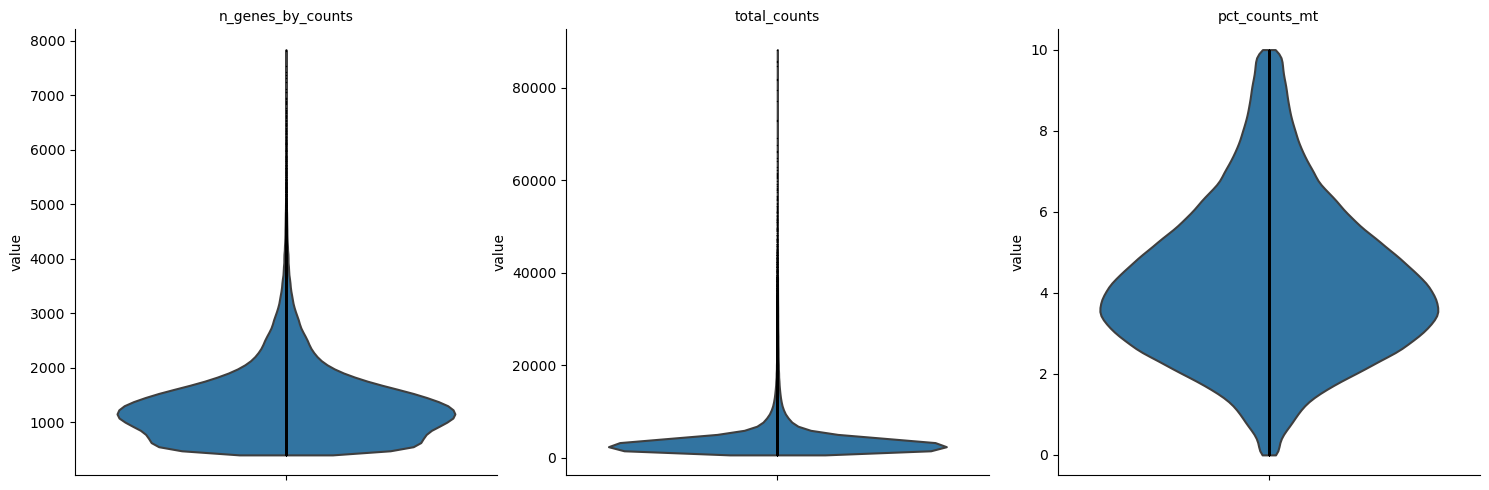

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.0, multi_panel=True)

In [17]:
# Log normalization scaled up to 10000
sc.pp.normalize_total(adata, target_sum=1e4)

/home/xinghua/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
# Logarithmize adata
sc.pp.log1p(adata, base=2)

In [19]:
# adata.write('/home/data/ICI_exprs/GSE169246/GSE169246_filtered-lux.h5ad')

In [20]:
# adata = sc.read_h5ad('/home/data/ICI_exprs/GSE169246/GSE169246_filtered-lux.h5ad')

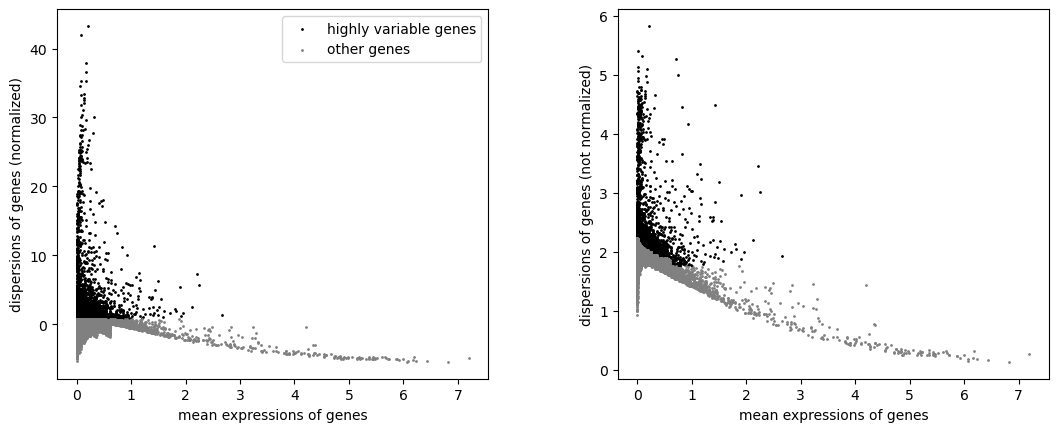

In [21]:
sc.pp.highly_variable_genes(adata, n_top_genes = 4000, flavor = 'cell_ranger')
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
sc.pl.highly_variable_genes(adata)

In [22]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
print('adata dimensions of high variance genes: ' + str(adata.shape))

adata dimensions of high variance genes: (489482, 4000)


In [23]:
# perform PCA   
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# Keep the top 50 components
#adata.obsm["X_pca"] = adata.obsm["X_pca"][:, :50]

In [24]:
print(adata.obsm['X_pca'].shape)
print(adata.varm['PCs'].shape)
print(adata.uns['pca']['variance_ratio'].shape)
print(adata.obs.columns)

(489482, 50)
(4000, 50)
(50,)
Index(['sample_id', 'patient_id', 'timepoint', 'sample_source', 'n_genes',
       'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')


### Clusterings

In [25]:
sc.pp.neighbors(adata, n_neighbors=80)

In [26]:
# Use the Leiden algorithm to find clusters
sc.tl.leiden(adata, resolution=0.5)


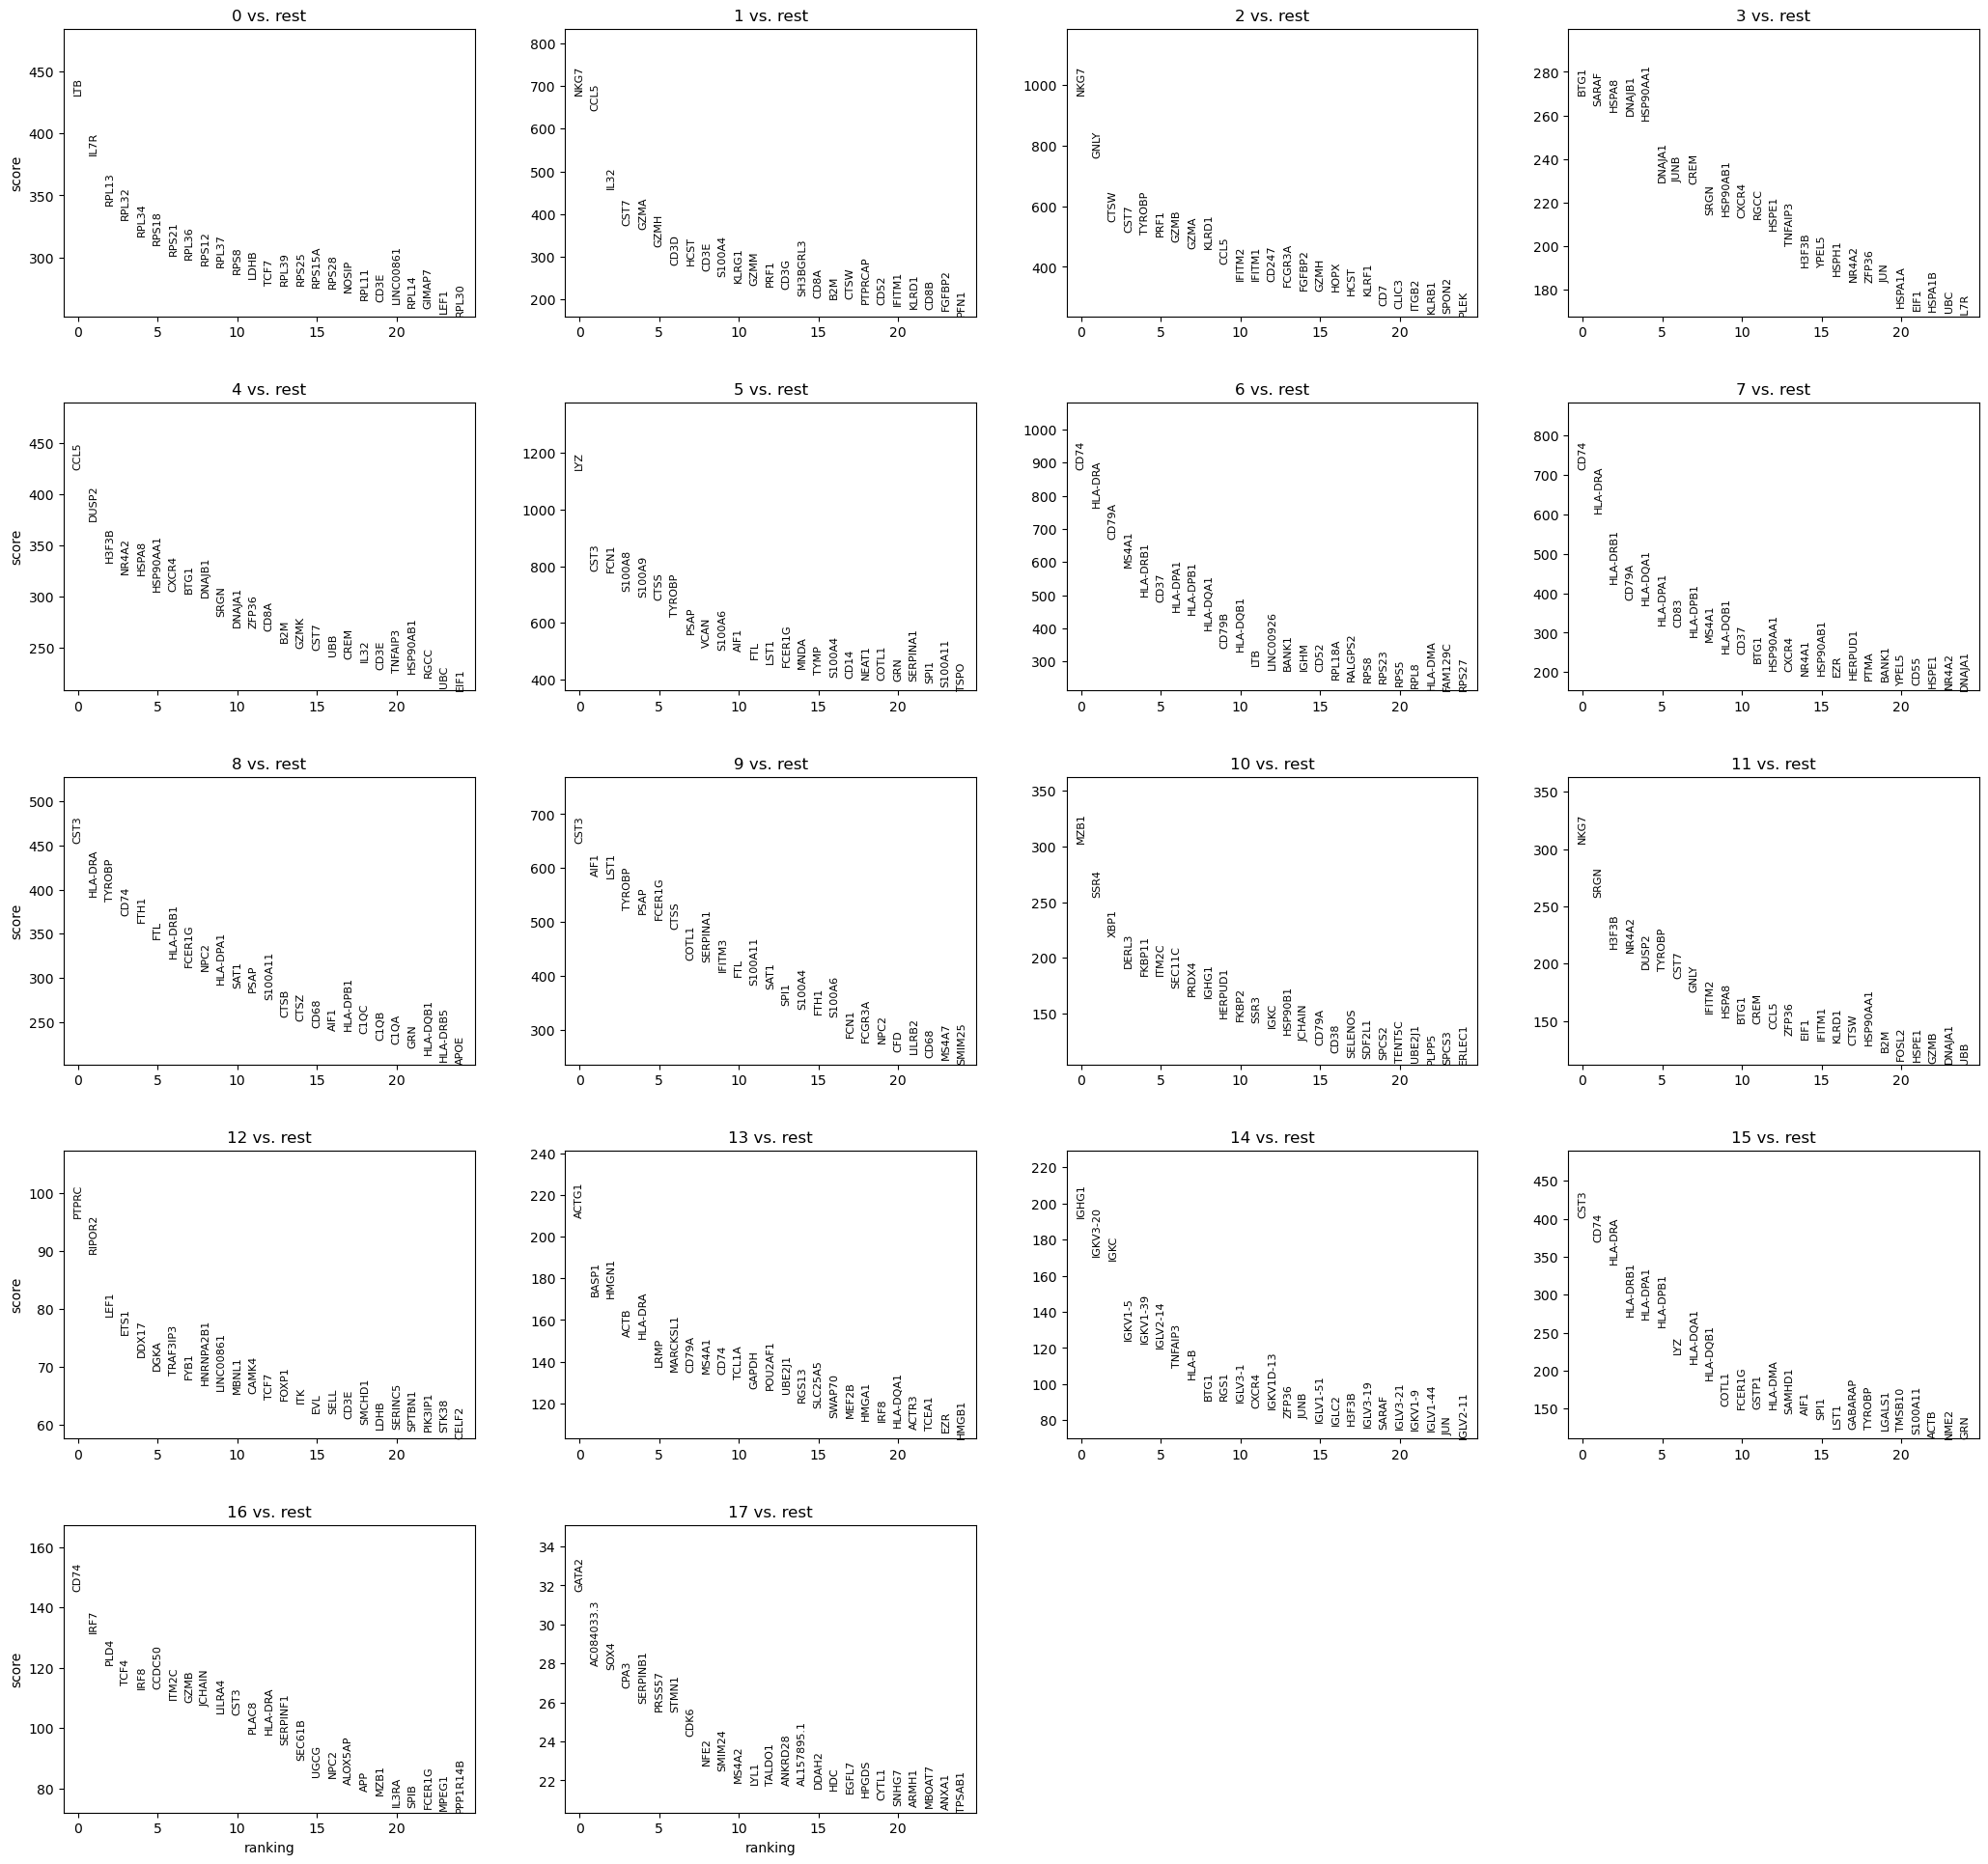

In [27]:
# load/find cell cycle markers: T-test/T-cells
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [28]:
# perform UMAP
sc.tl.umap(adata)


/home/xinghua/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


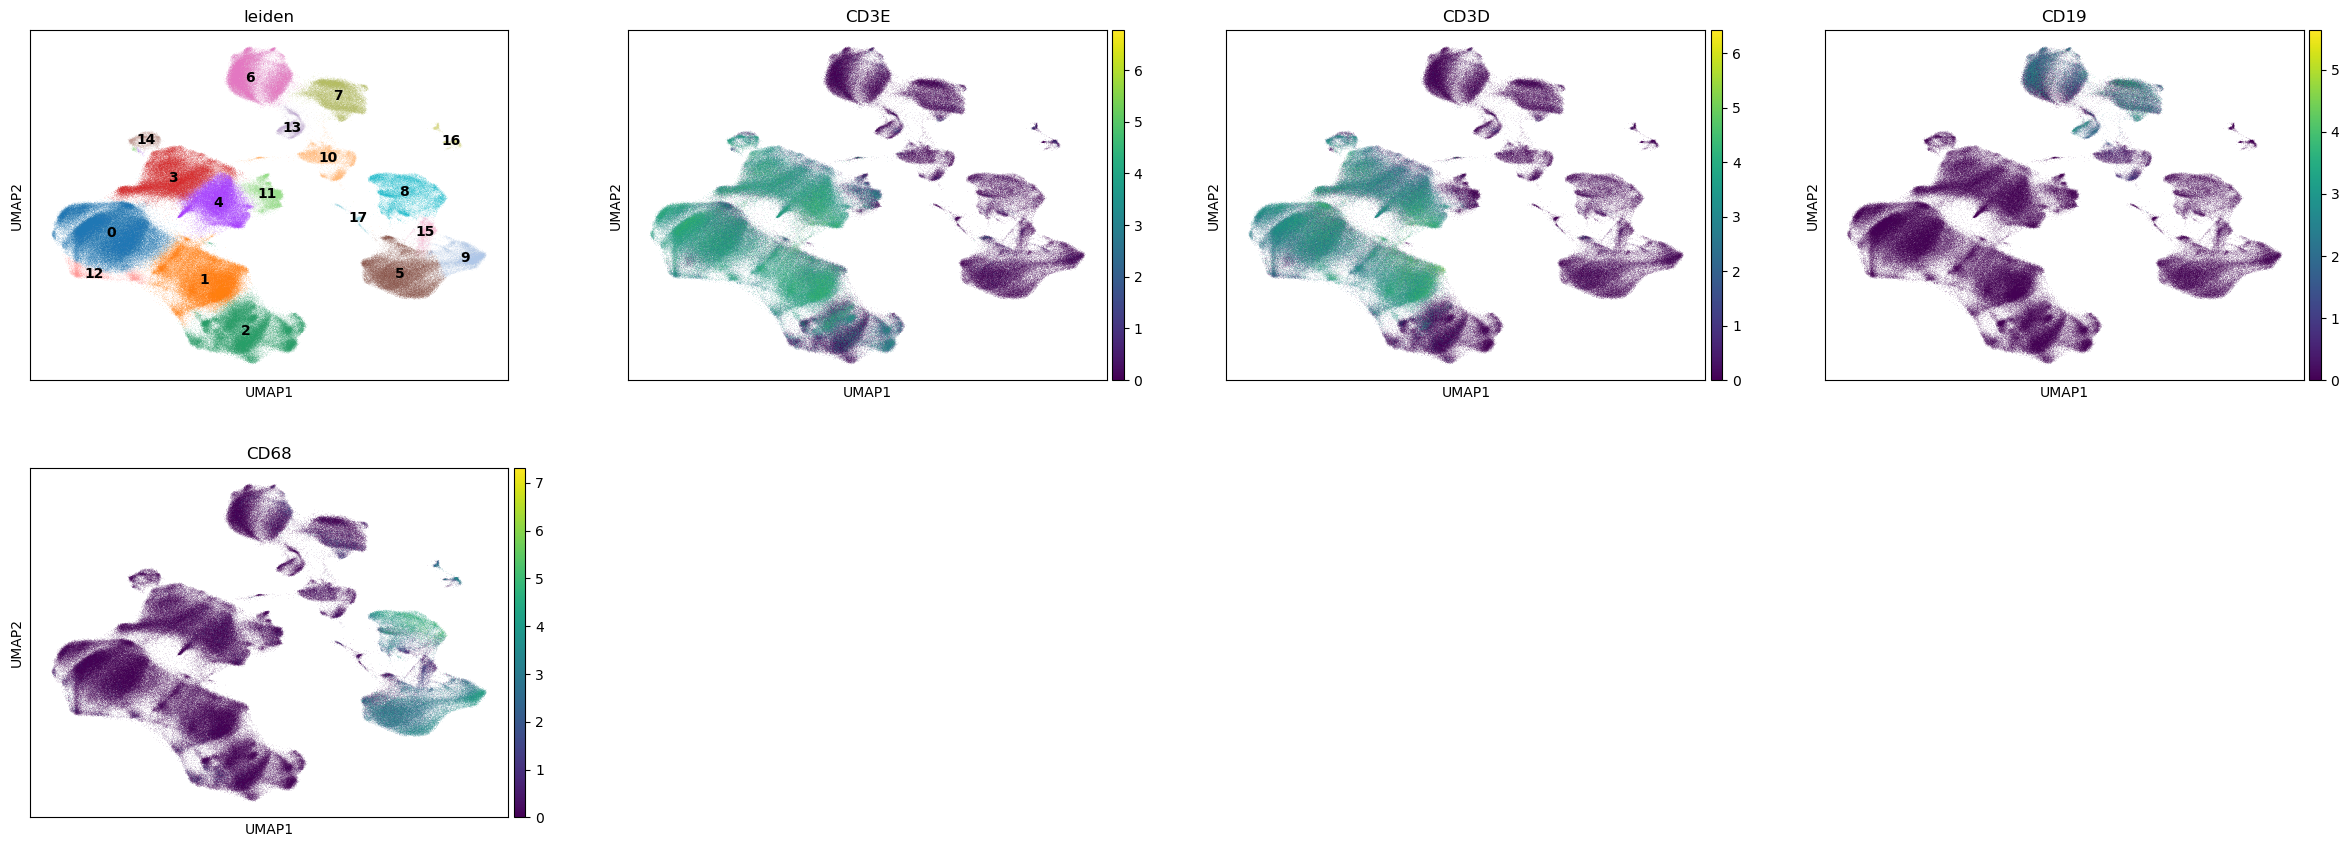

In [29]:
sc.pl.umap(adata, color=['leiden', 'CD3E', 'CD3D', 'CD19',  'CD68'] ,legend_loc='on data')
# plot B cells markers
# sc.pl.umap(adata, color=['MS4A1', 'CD79A', 'CD79B', 'CD19', 'CD20', 'CD22', 'CD27', 'CD38', 'CD45RA', 'CD45RO', 'CD69', 'CD80', 'CD86', 'CD95', 'CD274', 'CD276', 'CD319', 'CD320'], legend_loc='on data')

categories: 0, 1, 2, etc.
var_group_labels: T cells, B cells, Myeloid


/home/xinghua/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


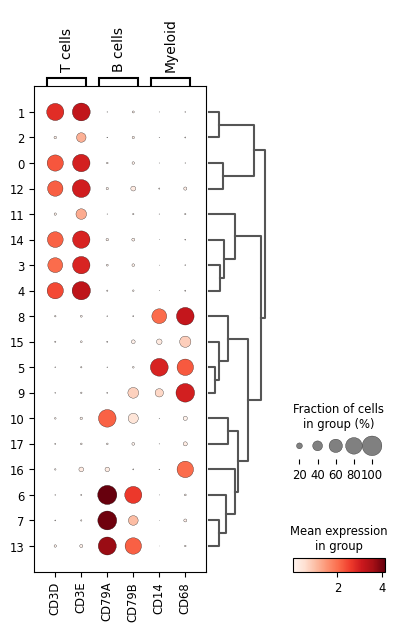

In [30]:
cell_type_markers = {
    'T cells': ['CD3D', 'CD3E'],
    'B cells': ['CD79A', 'CD79B'],
    'Myeloid': ['CD14', 'CD68']
}
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.dotplot(adata, cell_type_markers, 'leiden', dendrogram=True)
#sc.pl.umap(adata, color='clusters', legend_loc='on data')


T cells : ['CD3D', 'CD3E']


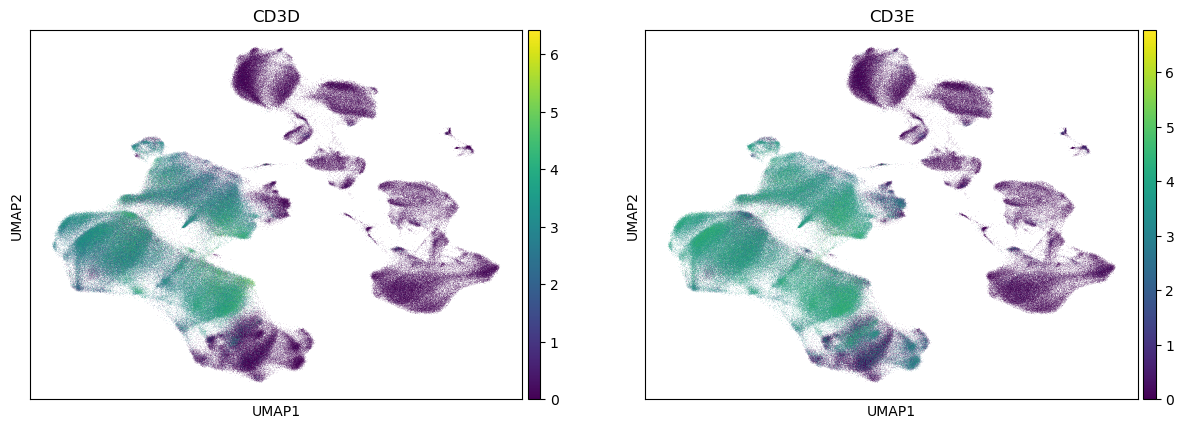

B cells : ['CD79A', 'CD79B']


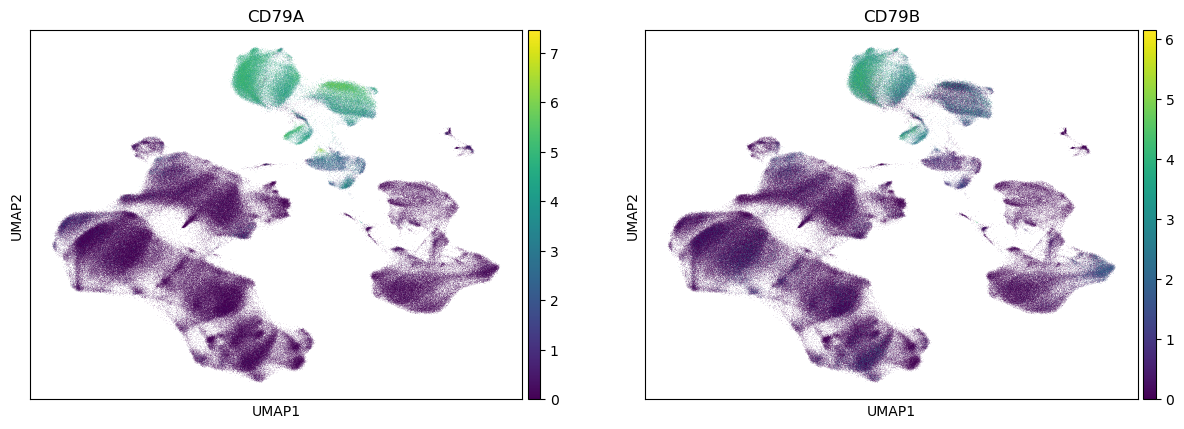

Myeloid : ['CD14', 'CD68']


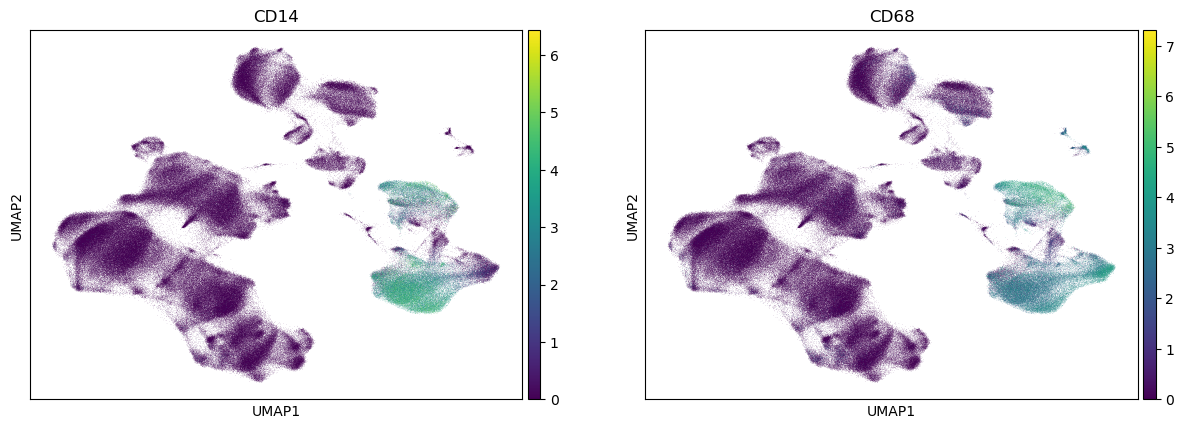

In [31]:
# check if the markers are in the var names
for cell_type, markers in cell_type_markers.items():
    print (cell_type, ":", markers)
    #print ("number of match in var: ", str(sum(adata.raw.var_names.isin(markers))))
    sc.pl.umap(adata, color=markers, legend_loc='on data')

In [32]:
def labelClusterWithCellType(adata, cell_type_markers, cluster_column='leiden'):
    '''
    This function will label each cluster with the cell type that is most abundant in that cluster.

    Parameters:
        adata: AnnData object
        cell_type_markers: a dictionary where the key is the cell type and the value is a list of markers for that cell type
        cluster_column: the column in adata.obs that contains the cluster labels

    Returns:
        adata: AnnData object with a new column in adata.obs called 'cell_type' that contains the cell type label for each cell
    
    '''

    # find total number of clusters   
    cls_ids = adata.obs[cluster_column].unique()
    
    # iterate through all cluster
    for i in cls_ids:
        # find cells in cluster i        
        cell_in_cls_i = adata.obs[cluster_column] == i  
        # this will return a vector of True/False where True means the cell is in cluster i
        # print('processing cluster: ' + str(i) + ' with ' + str(sum(cell_in_cls_i)) + ' cells')

        # keep track of which cell type is most abundant in cluster i
        cell_type_cluster_overlapp_pct = dict()

        #iterate through key and value of cell_type_markers
        for cell_type, marker_genes in cell_type_markers.items():   
            # Extract the expression of all marker genes for cells in cluster i
            # this will return a sparse matrix of cells x markers
            cell_w_marker_genes = adata.raw.X[:, adata.raw.var_names.isin(marker_genes)] > 0  
            
            # change cell_in_cls_i to numpy array and repeat it to match the shape of cell_w_marker_genes
            cell_in_cls_i_m = np.tile(cell_in_cls_i.to_numpy(), (cell_w_marker_genes.shape[1], 1)).T

            # find cells in cluster i that express the marker
            # this create a matrix of cells x markers where True means the cell express the marker and in cluster i
            cell_w_marker_genes = cell_w_marker_genes.toarray() & cell_in_cls_i_m

            # caclualte average markers expressed in each cell in Marker_genes_i
            nmarker_per_cell = np.sum(cell_w_marker_genes, axis=0) / cell_w_marker_genes.shape[1]
            #print(nmarker_per_cell)

            # keep track of which cell type is most abundant in cluster i
            # assuming the cell type with the highest average marker present is the most abundant         
            cell_type_cluster_overlapp_pct[cell_type] = np.sum(nmarker_per_cell) / sum(cell_in_cls_i)

        # check with cell type is most abundant in cluster i
        max_type = max(cell_type_cluster_overlapp_pct, key=cell_type_cluster_overlapp_pct.get)
        print('Cluster ' + str(i) + ' is most likely ' + max_type + ' with ' + str(cell_type_cluster_overlapp_pct[max_type]) + ' overlap')
        adata.obs.loc[cell_in_cls_i, 'cell_type'] = max_type      

In [33]:
labelClusterWithCellType(adata, cell_type_markers)

Cluster 2 is most likely T cells with 0.22334190395579476 overlap
Cluster 0 is most likely T cells with 0.8161523439436145 overlap
Cluster 1 is most likely T cells with 0.8585790884718498 overlap
Cluster 12 is most likely T cells with 0.805675442382391 overlap
Cluster 6 is most likely B cells with 0.8980485655790811 overlap
Cluster 9 is most likely Myeloid with 0.6264970714223271 overlap
Cluster 10 is most likely B cells with 0.6388608176389526 overlap
Cluster 4 is most likely T cells with 0.8454644860701721 overlap
Cluster 15 is most likely Myeloid with 0.33055775839280993 overlap
Cluster 5 is most likely Myeloid with 0.834249226006192 overlap
Cluster 16 is most likely Myeloid with 0.40121483375959077 overlap
Cluster 3 is most likely T cells with 0.7713070280997318 overlap
Cluster 11 is most likely T cells with 0.2496113486202876 overlap
Cluster 7 is most likely B cells with 0.6705995496340776 overlap
Cluster 17 is most likely Myeloid with 0.0649895178197065 overlap
Cluster 8 is most 

/home/xinghua/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


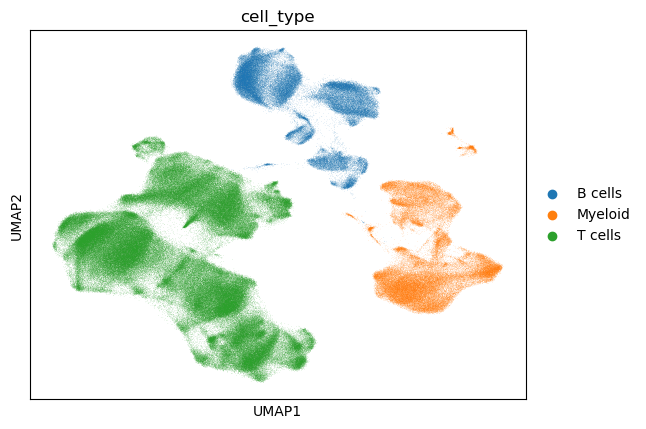

In [34]:
# plot umap with cell type labels
sc.pl.umap(adata, color='cell_type')

### Write to file.

In [42]:
# extract T cells and output  AnnData object to file
adata_T = adata[adata.obs['cell_type'] == 'T cells']
adata_T = ad.AnnData(X=adata_T.raw.X, obs=adata_T.obs, var=adata_T.raw.var)
adata_T = adata_T[:, adata_T.var_names.isin(cell_type_markers['T cells'])]
adata_T.write('/data/ICI_exprs/ICI_T_cell_collection/GSE169246_T_cells.h5ad')

# extract B cells
adata_B = adata[adata.obs['cell_type'] == 'B cells']
adata_B = ad.AnnData(X=adata_B.raw.X, obs=adata_B.obs, var=adata_B.raw.var)
adata_B.write_h5ad('/data/ICI_exprs/ICI_B_cell_collection/GSE169246_B_cells.h5ad')

# extract Myeloid cells
adata_M = adata[adata.obs['cell_type'] == 'Myeloid']
adata_M = ad.AnnData(X=adata_M.raw.X, obs=adata_M.obs, var=adata_M.raw.var)
adata_M.write_h5ad('/data/ICI_exprs/ICI_Myeloid_cell_collection/GSE169246_M_cells.h5ad')